In [9]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from rich.progress import track

from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import root_mean_squared_error

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

## Data loading

In [51]:
training_data = pd.read_csv("../data/03_splitted/European_Vanilla/training_data.csv")
test_data = pd.read_csv(
    "../data/03_splitted/European_Vanilla/testing_data.csv"
)


X_train = training_data.iloc[:, :-1]

y_train = training_data.iloc[:, -1]

X_test = test_data.iloc[:, :-1]

y_test = test_data.iloc[:, -1]

In [52]:
X_train

,stock_price,strike_price,time_to_maturity,interest_rate,volatility,dividend_yield,1_over_T,log_T,sqrt_T,log1p_T,...,dividend_yield_over_interest_times_interest_rate_over_volatility,dividend_yield_over_interest_times_dividend_yield_over_volatility,dividend_yield_over_interest_times_stock_price_over_volatility,stock_price_over_interest_times_interest_rate_over_volatility,stock_price_over_interest_times_dividend_yield_over_volatility,stock_price_over_interest_times_stock_price_over_volatility,interest_rate_over_volatility_times_dividend_yield_over_volatility,interest_rate_over_volatility_times_stock_price_over_volatility,dividend_yield_over_volatility_times_stock_price_over_volatility,option_type_put
0,-0.407620,0.0,-0.947531,0.704448,1.483651,-0.87831,-0.051197,-0.671972,-0.914853,-0.969502,...,-0.745565,-0.452391,-0.497200,-0.834040,-0.497200,-0.544621,-0.435129,-0.502795,-0.514449,1.0
1,0.271746,0.0,0.330326,-1.286384,-0.858956,-0.87831,-0.493977,0.610099,0.511216,0.551933,...,-0.433468,-0.291115,0.229072,0.368096,0.229072,1.528888,-0.418172,-0.438599,-0.315973,1.0
2,1.154923,0.0,1.927648,-0.061256,-0.078087,1.46385,-0.549325,1.162257,1.579798,1.519773,...,0.190726,-0.040860,-0.054340,-0.205016,-0.054340,-0.265120,-0.250602,-0.381377,-0.200761,0.0
3,1.562542,0.0,0.010862,1.470153,-0.858956,-0.87831,-0.466303,0.432344,0.238861,0.275135,...,-0.433468,-0.441269,-0.416554,0.899273,-0.416554,-0.204038,-0.130909,0.861651,-0.242392,0.0
4,1.290796,0.0,-0.947531,-0.061256,-0.078087,-1.46385,-0.051197,-0.671972,-0.914853,-0.969502,...,-0.849597,-0.457952,-0.517476,-0.177059,-0.517476,-0.245341,-0.450090,-0.376568,-0.525098,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107095,1.494606,0.0,-0.947531,-0.061256,-0.858956,-0.87831,-0.051197,-0.671972,-0.914853,-0.969502,...,-0.433468,-0.424585,-0.318397,0.871316,-0.318397,0.162384,-0.290500,0.149975,-0.246265,0.0
107096,0.475556,0.0,1.927648,1.470153,-1.249390,1.46385,-0.549325,1.162257,1.579798,1.519773,...,3.311696,0.376233,0.270547,2.045496,0.270547,-0.119031,5.933540,3.842995,3.889762,0.0
107097,-0.747303,0.0,-1.107263,1.470153,-0.078087,-0.29277,0.502279,-1.224130,-1.252769,-1.296884,...,-0.433468,-0.424585,-0.463559,-0.596409,-0.463559,-0.536247,-0.290500,-0.354930,-0.449581,1.0
107098,1.222859,0.0,0.649790,1.470153,-1.249390,0.87831,-0.512426,0.755336,0.757444,0.791707,...,2.479437,0.075926,0.234602,2.660543,0.234602,0.080941,4.656814,4.689312,3.688383,1.0


In [53]:
print(X_train.describe())

         stock_price  strike_price  time_to_maturity  interest_rate  \
count  107100.000000      107100.0     107100.000000  107100.000000   
mean       -0.000785           0.0          0.000727      -0.001430   
std         0.999033           0.0          0.999708       0.999816   
min        -1.698416           0.0         -1.215881      -1.286384   
25%        -0.883176           0.0         -0.947531      -0.826961   
50%         0.000000           0.0          0.010862      -0.061256   
75%         0.883176           0.0          0.649790       0.704448   
max         1.698416           0.0          1.927648       1.470153   

          volatility  dividend_yield       1_over_T          log_T  \
count  107100.000000   107100.000000  107100.000000  107100.000000   
mean       -0.001531       -0.000705      -0.001205       0.001195   
std         0.999844        1.000628       0.998832       0.999244   
min        -1.249390       -1.463850      -0.549325      -2.131798   
25%       

## Data preparation

In [54]:
# Dropping columns with no change in values
Columns_variance_filter = X_train.loc[:, X_train.var() > 1e-2].columns.tolist()

# Dropping columns with low correlation to the target variable
df = X_train.copy()
df["y"] = y_train
corr = df.corr()
Columns_correlation_filter = corr["y"].abs()[corr["y"].abs() > 0.05].index.tolist()

# Selecting top 40 features using mutual information regression
Feature_selection = SelectKBest(f_regression, k=40).fit(X_train, y_train)
Top_40_columns = X_train.columns[Feature_selection.get_support(indices=True)]

top_variables = set(Top_40_columns).intersection(set(Columns_variance_filter).intersection(set(Columns_correlation_filter)))

X_train_top_vars = X_train[list(top_variables)]
X_test_top_vars = X_test[list(top_variables)]

In [55]:
X_train.shape

(107100, 191)

Number of components to explain 0.98 variance: 22


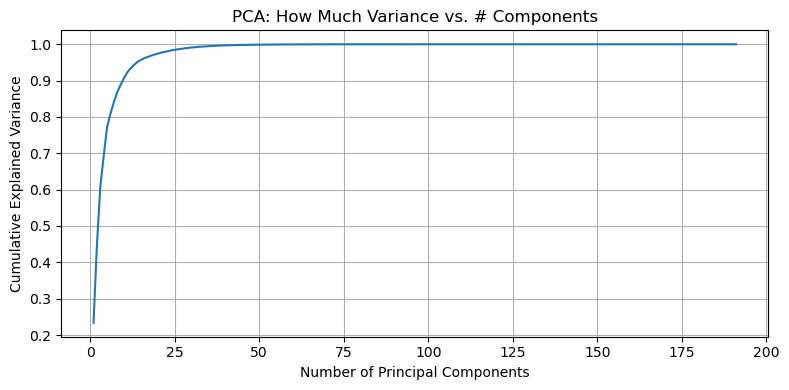

In [57]:
pca_full = PCA(random_state=2025)
pca_full.fit(X_train)
cum_var = np.cumsum(pca_full.explained_variance_ratio_)

Var_threshold = 0.98
Number_of_components = np.where(cum_var > Var_threshold)[0][0]
print(
    f"Number of components to explain {Var_threshold} variance: {Number_of_components}"
)

pca = PCA(n_components=Number_of_components, random_state=2025)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# # Plotting the explained variance ratio
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(cum_var) + 1), cum_var)
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA: How Much Variance vs. # Components")
plt.grid(True)
plt.tight_layout()
plt.show()

In [58]:
pca_full.fit(X_train)

PCA(random_state=2025)

In [59]:
pca_full.feature_names_in_

array(['stock_price', 'strike_price', 'time_to_maturity', 'interest_rate',
       'volatility', 'dividend_yield', '1_over_T', 'log_T', 'sqrt_T',
       'log1p_T', 'variance', 'stock_over_strike', 'strike_over_stock',
       'volatility_over_interest', 'dividend_yield_over_interest',
       'stock_price_over_interest', 'interest_rate_over_volatility',
       'dividend_yield_over_volatility', 'stock_price_over_volatility',
       'stock_price_times_strike_price',
       'stock_price_times_time_to_maturity',
       'stock_price_times_interest_rate', 'stock_price_times_volatility',
       'stock_price_times_dividend_yield', 'stock_price_times_1_over_T',
       'stock_price_times_log_T', 'stock_price_times_sqrt_T',
       'stock_price_times_log1p_T', 'stock_price_times_variance',
       'stock_price_times_stock_over_strike',
       'stock_price_times_strike_over_stock',
       'stock_price_times_volatility_over_interest',
       'stock_price_times_dividend_yield_over_interest',
       'stoc

In [60]:
cum_var = np.cumsum(pca_full.explained_variance_ratio_)

In [61]:
cum_var

array([0.23361414, 0.44698248, 0.60719297, 0.69175509, 0.7715203 ,
       0.8089286 , 0.84016889, 0.8681451 , 0.88830133, 0.90699469,
       0.92277732, 0.93429531, 0.94325989, 0.95141175, 0.95665736,
       0.96152669, 0.96509428, 0.96846322, 0.97165327, 0.97430806,
       0.97681196, 0.97896269, 0.98110644, 0.98311873, 0.9848137 ,
       0.98623045, 0.98758126, 0.98890246, 0.99006206, 0.99109831,
       0.99202788, 0.99286334, 0.9935482 , 0.9941899 , 0.99477583,
       0.99531601, 0.99582089, 0.99626737, 0.99664028, 0.99699316,
       0.99733187, 0.99758235, 0.99781148, 0.99801333, 0.99819093,
       0.99836161, 0.99852538, 0.99866378, 0.99878381, 0.9989007 ,
       0.99900878, 0.99910955, 0.99919883, 0.99927581, 0.99935117,
       0.99941087, 0.99946634, 0.99951986, 0.99956824, 0.9996118 ,
       0.99965418, 0.99969316, 0.99972546, 0.99975468, 0.99978353,
       0.99981085, 0.99983331, 0.9998549 , 0.99987202, 0.99988893,
       0.99990215, 0.99991211, 0.9999203 , 0.99992836, 0.99993

In [6]:
data_modes = {
    "all_variables": {
        "X_train": X_train,
        "X_test": X_test,
    },
    "top_vars": {
        "X_train": X_train_top_vars,
        "X_test": X_test_top_vars,
    },
    "pca": {
        "X_train": X_train_pca,
        "X_test": X_test_pca,
    },
}

In [7]:
results = []
detailed_results = []

In [10]:
family_name = "linear_models"
print(f"Running {family_name} family:\n")


linear_models = {
    "LinearRegression": {
        "model": LinearRegression(),
        "grid": {"fit_intercept": [True, False]},
    },
    "Ridge": {"model": Ridge(), "grid": {"alpha": [0.1, 1.0, 10.0]}},
}

for model_name, settings in linear_models.items():
    for data_mode, data in track(
        data_modes.items(),
        description=f"Running different data modes for {model_name} model:",
    ):
        X_train_temp = data_modes[data_mode]["X_train"]
        X_test_temp = data_modes[data_mode]["X_test"]

        model = settings["model"]
        param_grid = settings["grid"]
        gs = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            scoring="neg_root_mean_squared_error",
            cv=3,
            n_jobs=-1,
            verbose=10,
        )

        start = time.time()
        gs.fit(X_train_temp, y_train)
        elapsed = time.time() - start

        best = gs.best_estimator_
        train_rmse = root_mean_squared_error(y_train, best.predict(X_train_temp))
        test_rmse = root_mean_squared_error(y_test, best.predict(X_test_temp))

        detailed_results.append(
            {
                "family": family_name,
                "model": model_name,
                "data_mode": data_mode,
                "gs_object": gs,
                "best_estimator": best,
            }
        )

        results.append(
            {
                "family": family_name,
                "model": model_name,
                "data_mode": data_mode,
                "train_rmse": train_rmse,
                "test_rmse": test_rmse,
                "time_s": elapsed,
            }
        )

Output()

Fitting 3 folds for each of 2 candidates, totalling 6 fits

Running linear_models family:



Fitting 3 folds for each of 2 candidates, totalling 6 fits

Fitting 3 folds for each of 2 candidates, totalling 6 fits

Output()

Fitting 3 folds for each of 3 candidates, totalling 9 fits

Fitting 3 folds for each of 3 candidates, totalling 9 fits

Fitting 3 folds for each of 3 candidates, totalling 9 fits

In [11]:
family_name = "tree_models"
print(f"Running {family_name} family:\n")


tree_models = {
    "RandomForestRegressor": {
        "model": RandomForestRegressor(random_state=2025),
        "grid": {"n_estimators": [10, 40], "max_depth": [5, 10]},
    },
    "XGBRegressor": {
        "model": XGBRegressor(tree_method="hist", random_state=2025, verbosity=1),
        "grid": {
            "n_estimators": [10, 40],
            "learning_rate": [0.01, 0.1],
            "max_depth": [2, 6],
        },
    },
}

for model_name, settings in tree_models.items():
    print(f"Running {model_name} model:\n")
    for data_mode, data in track(
        data_modes.items(),
        description=f"Running different data modes for {model_name} model:",
    ):
        # if data_mode == "all_variables":
        #     #skipping this combination as it takes too long
        #     continue

        X_train_temp = data_modes[data_mode]["X_train"]
        X_test_temp = data_modes[data_mode]["X_test"]

        model = settings["model"]
        param_grid = settings["grid"]
        gs = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            scoring="neg_root_mean_squared_error",
            cv=3,
            n_jobs=-1,
            verbose=10,
        )

        start = time.time()
        if data_mode == "all_variables":
            # sampling 40% of the data for faster computation
            ratio = 0.4
            full_len = len(X_train_temp)
            sample_size = int(ratio*full_len)
            sample_indices = np.random.choice(full_len, size=sample_size , replace=False)
            gs.fit(X_train_temp.iloc[sample_indices], y_train.iloc[sample_indices])
        else:
            gs.fit(X_train_temp, y_train)
            
        elapsed = time.time() - start

        best = gs.best_estimator_
        train_rmse = root_mean_squared_error(y_train, best.predict(X_train_temp))
        test_rmse = root_mean_squared_error(y_test, best.predict(X_test_temp))

        detailed_results.append(
            {
                "family": family_name,
                "model": model_name,
                "data_mode": data_mode,
                "gs_object": gs,
                "best_estimator": best,
            }
        )

        results.append(
            {
                "family": family_name,
                "model": model_name,
                "data_mode": data_mode,
                "train_rmse": train_rmse,
                "test_rmse": test_rmse,
                "time_s": elapsed,
            }
        )

Output()

Fitting 3 folds for each of 4 candidates, totalling 12 fits

Running tree_models family:

Running RandomForestRegressor model:



Fitting 3 folds for each of 4 candidates, totalling 12 fits

Fitting 3 folds for each of 4 candidates, totalling 12 fits

Output()

Fitting 3 folds for each of 8 candidates, totalling 24 fits

Running XGBRegressor model:



Fitting 3 folds for each of 8 candidates, totalling 24 fits

Fitting 3 folds for each of 8 candidates, totalling 24 fits

In [23]:
family_name = "kernel_models"
print(f"Running {family_name} family:\n")


kernel_models = {
    "SVR": {
        "model": SVR(),
        "grid": {
            "kernel": ["linear", "rbf"],
            "C": [0.1, 1.0, 10.0],
        },
    },
    "KNeighborsRegressor": {
        "model": KNeighborsRegressor(),
        "grid": {
            "n_neighbors": [3, 5, 10],
            "leaf_size": [10, 20],
            "weights": ["uniform", "distance"],
        },
    },
}

for model_name, settings in kernel_models.items():
    print(f"Running {model_name} model:\n")
    for data_mode, data in track(
        data_modes.items(),
        description=f"Running different data modes for {model_name} model:",
    ):
        if data_mode == "all_variables":
            # skipping this combination as it takes too long
            continue

        size_reduction_factor = 0.1
        size_limit = int(len(X_train) * size_reduction_factor)

        X_train_temp = data_modes[data_mode]["X_train"]
        X_test_temp = data_modes[data_mode]["X_test"]

        model = settings["model"]
        param_grid = settings["grid"]
        gs = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            scoring="neg_root_mean_squared_error",
            cv=3,
            n_jobs=-1,
            verbose=10,
        )

        start = time.time()
        if model_name == "SVR":
            # SVR is slow, so we limit the size of the training set
            ratio = 0.4
            full_len = len(X_train_temp)
            sample_size = int(ratio * full_len)
            sample_indices = np.random.choice(full_len, size=sample_size, replace=False)
            if data_mode == "pca":
                gs.fit(X_train_temp[sample_indices], y_train[sample_indices])
            else:
                gs.fit(X_train_temp.iloc[sample_indices], y_train.iloc[sample_indices])
        else:
            gs.fit(X_train_temp, y_train)
        elapsed = time.time() - start

        best = gs.best_estimator_
        train_rmse = root_mean_squared_error(y_train, best.predict(X_train_temp))
        test_rmse = root_mean_squared_error(y_test, best.predict(X_test_temp))

        detailed_results.append(
            {
                "family": family_name,
                "model": model_name,
                "data_mode": data_mode,
                "gs_object": gs,
                "best_estimator": best,
            }
        )

        results.append(
            {
                "family": family_name,
                "model": model_name,
                "data_mode": data_mode,
                "train_rmse": train_rmse,
                "test_rmse": test_rmse,
                "time_s": elapsed,
            }
        )

Output()

Fitting 3 folds for each of 6 candidates, totalling 18 fits

Running kernel_models family:

Running SVR model:



Fitting 3 folds for each of 6 candidates, totalling 18 fits

Output()

Fitting 3 folds for each of 12 candidates, totalling 36 fits

Running KNeighborsRegressor model:



Fitting 3 folds for each of 12 candidates, totalling 36 fits

In [ ]:
family_name = "neural_networks"
print(f"Running {family_name} family:\n")

neural_networks = {
    "MLPRegressor": {
        "model": MLPRegressor(max_iter=100, random_state=2025),
        "grid": {
            "hidden_layer_sizes": [
                (10,),
                (50,),
                (
                    20,
                    20,
                    20,
                    20,
                ),
                (
                    50,
                    50,
                ),
            ],
            "learning_rate" : ["constant", "adaptive"],
        },
    },
}

for model_name, settings in neural_networks.items():
    print(f"Running {model_name} model:\n")
    for data_mode, data in track(
        data_modes.items(), description=f"data mode {data_mode}"
    ):

        X_train_temp = data_modes[data_mode]["X_train"]
        X_test_temp = data_modes[data_mode]["X_test"]

        model = settings["model"]
        param_grid = settings["grid"]
        gs = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            scoring="neg_root_mean_squared_error",
            cv=3,
            n_jobs=-1,
            verbose=10,
        )

        start = time.time()
        gs.fit(X_train_temp, y_train)
        elapsed = time.time() - start

        best = gs.best_estimator_
        train_rmse = root_mean_squared_error(y_train, best.predict(X_train_temp))
        test_rmse = root_mean_squared_error(y_test, best.predict(X_test_temp))

        detailed_results.append(
            {
                "family": family_name,
                "model": model_name,
                "data_mode": data_mode,
                "gs_object": gs,
                "best_estimator": best,
            }
        )

        results.append(
            {
                "family": family_name,
                "model": model_name,
                "data_mode": data_mode,
                "train_rmse": train_rmse,
                "test_rmse": test_rmse,
                "time_s": elapsed,
            }
        )

In [25]:
df_res = pd.DataFrame(results)
df_res.to_csv("../data/model_comparison.csv", index=False)

In [30]:
# sorting the results by test RMSE
df_res = df_res.sort_values(by="test_rmse", ascending=True)

In [ ]:
res

,family,model,data_mode,train_rmse,test_rmse,time_s
17,neural_networks,MLPRegressor,all_variables,0.123708,0.126545,195.489719
6,tree_models,RandomForestRegressor,all_variables,1.410795,1.479449,94.424464
9,tree_models,XGBRegressor,all_variables,1.780234,1.816019,5.967923
3,linear_models,Ridge,all_variables,14.736521,14.771522,1.667021
0,linear_models,LinearRegression,all_variables,14.735357,14.775409,2.637734
19,neural_networks,MLPRegressor,pca,14.863146,14.931972,44.703610
18,neural_networks,MLPRegressor,top_vars,14.931038,14.991607,61.920154
10,tree_models,XGBRegressor,top_vars,14.894132,15.108828,2.120064
1,linear_models,LinearRegression,top_vars,15.107729,15.131399,1.177354
4,linear_models,Ridge,top_vars,15.107734,15.131420,0.256812


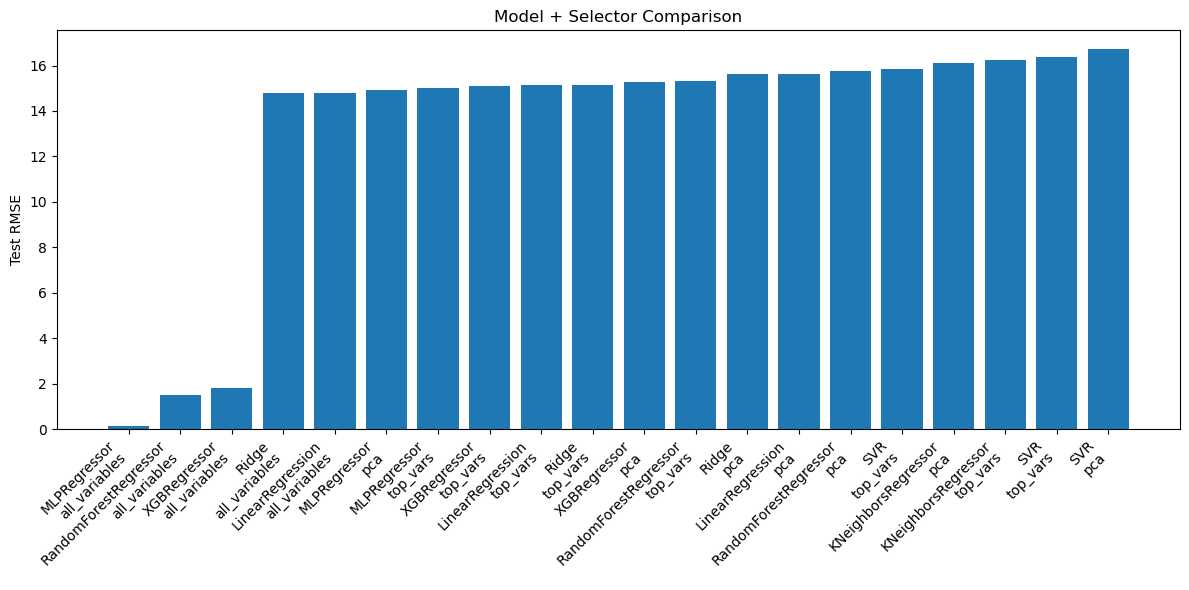

In [31]:
plt.figure(figsize=(12, 6))
labels = df_res["model"] + "\n" + df_res["data_mode"]
plt.bar(x=np.arange(len(df_res)), height=df_res["test_rmse"], tick_label=labels)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Test RMSE")
plt.title("Model + Selector Comparison")
plt.tight_layout()
plt.show()